In [1]:
### 0. Load necessary packages

# General, data handling and visualization
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessing, ML model training & validation
from sklearn.utils import resample
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import autosklearn.classification
import sklearn.metrics
from sklearn.externals import joblib # to save models

# Pipelining & PMML export
from sklearn.pipeline import Pipeline
#from sklearn2pmml.pipeline import PMMLPipeline
#from sklearn2pmml import sklearn2pmml

print('Packages successfully loaded.')

Packages successfully loaded.


In [2]:
### Read in a sample dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data[:,:5] # only first 5 columns to make some testing easier
y = data.target
col_names = data.feature_names[:5]

print(X.shape)
print(y.shape)

#print(X[:4,:])
print(col_names)

## Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

(569, 5)
(569,)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']


In [3]:
def predict(model, X):
    predictions = model.predict_proba(X)[:,1]

    return predictions.tolist()

def validate(model, X, y):
    # predict
    predictions_prob = predict(model,X)
    predictions_rounded = np.round(predictions_prob)

    # find roc curve
    fpr,tpr,_ = sklearn.metrics.roc_curve(y, predictions_prob)
    roc_curve = {'false_positive_rate':fpr.tolist(),'true_positive_rate':tpr.tolist()}

    # find auc
    auc = sklearn.metrics.auc(fpr,tpr)

    # find accuracy
    acc = sklearn.metrics.accuracy_score(y, predictions_rounded,normalize=True)

    # find log_loss
    log_loss = sklearn.metrics.log_loss(y, predictions_prob)

    # find precision
    precision = sklearn.metrics.precision_score(y,predictions_rounded)

    # find recall
    recall = sklearn.metrics.recall_score(y,predictions_rounded)
    
    # find specificity
    specificity = sklearn.metrics.recall_score(1-y,1-predictions_rounded)

    # find f1-score
    f1score = sklearn.metrics.f1_score(y,predictions_rounded)

    # find precision-recall curve
    prec, rec, _ = precision_recall_curve = sklearn.metrics.precision_recall_curve(y,predictions_prob)
    precision_recall_curve = {'recall':rec.tolist(),'precision':prec.tolist()}

    # find confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y, predictions_rounded).tolist()

    print('area_under_curve: '+'{:.3f}'.format(auc))
    print('accuracy: '+'{:.3f}'.format(acc))
    print('log_loss: '+'{:.3f}'.format(log_loss))
    print('precision: '+'{:.3f}'.format(precision))
    print('recall: '+'{:.3f}'.format(recall))
    print('specificity: '+'{:.3f}'.format(specificity))
    print('f1_score: '+'{:.3f}'.format(f1score))
    print()
        
    print('confusion_matrix:')
    print(confusion_matrix)
    print()
    
    print('roc_curve:')
    plot_ROC_curve(roc_curve, auc)
    print()
    
    print('precision_recall_curve:')
    plot_precision_recall_curve(precision_recall_curve)


def plot_ROC_curve(roc_curve, auc):
    plt.figure()
    lw = 2
    plt.plot(roc_curve['false_positive_rate'], roc_curve['true_positive_rate'], color='darkorange',
         lw=lw, label='ROC curve (AUC = '+'{:.3f}'.format(auc)+')')
    plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.clf()
    
def plot_precision_recall_curve(precision_recall_curve):
    plt.figure()
    lw = 2
    plt.plot(precision_recall_curve['recall'], precision_recall_curve['precision'], color='blue',
         lw=lw, label='precision-recall curve')
    plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.clf()    

area_under_curve: 0.979
accuracy: 0.909
log_loss: 0.262
precision: 0.871
recall: 1.000
specificity: 0.764
f1_score: 0.931

confusion_matrix:
[[42, 13], [0, 88]]

roc_curve:


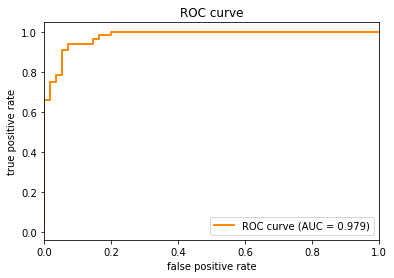


precision_recall_curve:


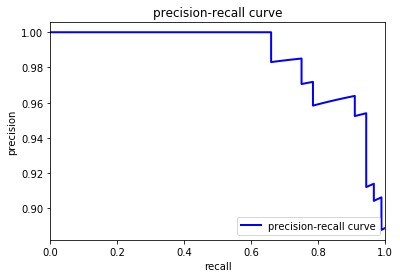

In [4]:
### LOGISTIC REGRESSION WITHOUT BALANCING

## Create logistic regression classifier object (other pipeline elements are defined already above)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
scale = StandardScaler(with_mean=False)
LR_clf = LogisticRegression()

## Create pipeline
logistic_regression_pipeline = Pipeline([('imputation', imp),
                                         ('scaling', scale),
                                         ('classifier', LR_clf)])

## Fit the pipeline - it's necessary to specify the option 'records' in the to_dict() function
logistic_regression_pipeline.fit(X_train, y_train)

## Test the pipeline by making predictions and computing metrics
validate(logistic_regression_pipeline, X_test, y_test)

In [5]:
#print(logistic_regression_pipeline.predict(X_test[0]))
print()
print(list(logistic_regression_pipeline.predict(X_test[:2,:])))


[1, 1]


In [6]:
features_df = pd.DataFrame(X_test, columns = col_names)
features_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness
0,8.598,20.98,54.66,221.8,0.12430
1,10.880,15.62,70.41,358.9,0.10070
2,13.780,15.79,88.37,585.9,0.08817
3,11.600,24.49,74.23,417.2,0.07474
4,10.650,25.22,68.01,347.0,0.09657


In [15]:
from flask import Flask, jsonify
import json

# this won't work without app context
#jsonify(features_df.head())

features_dict = features_df.head(9).to_dict()

print(features_dict)
print()

json_string = json.dumps(features_dict)
print(json_string)
print()

loaded_dict = json.loads(json_string)
print(loaded_dict)
print()

query_df = pd.DataFrame(loaded_dict, columns=loaded_dict.keys())

query_df

{'mean radius': {0: 8.598, 1: 10.88, 2: 13.78, 3: 11.6, 4: 10.65, 5: 19.8, 6: 12.1, 7: 15.13, 8: 18.82}, 'mean texture': {0: 20.98, 1: 15.62, 2: 15.79, 3: 24.49, 4: 25.22, 5: 21.56, 6: 17.72, 7: 29.81, 8: 21.97}, 'mean perimeter': {0: 54.66, 1: 70.41, 2: 88.37, 3: 74.23, 4: 68.01, 5: 129.7, 6: 78.07, 7: 96.71, 8: 123.7}, 'mean area': {0: 221.8, 1: 358.9, 2: 585.9, 3: 417.2, 4: 347.0, 5: 1230.0, 6: 446.2, 7: 719.5, 8: 1110.0}, 'mean smoothness': {0: 0.1243, 1: 0.1007, 2: 0.08817, 3: 0.07474, 4: 0.09657, 5: 0.09383, 6: 0.1029, 7: 0.0832, 8: 0.1018}}

{"mean radius": {"0": 8.598, "1": 10.88, "2": 13.78, "3": 11.6, "4": 10.65, "5": 19.8, "6": 12.1, "7": 15.13, "8": 18.82}, "mean texture": {"0": 20.98, "1": 15.62, "2": 15.79, "3": 24.49, "4": 25.22, "5": 21.56, "6": 17.72, "7": 29.81, "8": 21.97}, "mean perimeter": {"0": 54.66, "1": 70.41, "2": 88.37, "3": 74.23, "4": 68.01, "5": 129.7, "6": 78.07, "7": 96.71, "8": 123.7}, "mean area": {"0": 221.8, "1": 358.9, "2": 585.9, "3": 417.2, "4": 3

,mean radius,mean texture,mean perimeter,mean area,mean smoothness
0,8.598,20.98,54.66,221.8,0.12430
1,10.880,15.62,70.41,358.9,0.10070
2,13.780,15.79,88.37,585.9,0.08817
3,11.600,24.49,74.23,417.2,0.07474
4,10.650,25.22,68.01,347.0,0.09657
5,19.800,21.56,129.70,1230.0,0.09383
6,12.100,17.72,78.07,446.2,0.10290
7,15.130,29.81,96.71,719.5,0.08320
8,18.820,21.97,123.70,1110.0,0.10180


In [24]:
print(logistic_regression_pipeline.predict_proba(features_df.head(9))[:,1])
print()
print(logistic_regression_pipeline.predict_proba(query_df)[:,1])

[ 0.79144561  0.91757698  0.84080338  0.90066655  0.83997748  0.01454409
  0.85274319  0.3877791   0.02989839]

[ 0.79144561  0.91757698  0.84080338  0.90066655  0.83997748  0.01454409
  0.85274319  0.3877791   0.02989839]


In [17]:
col_names = ['var_1', 'var_2', 'var_3']
input_variables =  [[1], [2], [3]]
zipped = list(zip(col_names, input_variables))
zipped

[('var_1', [1]), ('var_2', [2]), ('var_3', [3])]

In [18]:
data = dict(zipped)
data

{'var_1': [1], 'var_2': [2], 'var_3': [3]}

In [19]:
df_1 = pd.DataFrame(data)
df_1

,var_1,var_2,var_3
0,1,2,3


In [20]:
json_string = json.dumps(data)
json_string


'{"var_1": [1], "var_2": [2], "var_3": [3]}'

In [25]:
joblib.dump(logistic_regression_pipeline, 'wisconsin_model.pkl')
joblib.dump(col_names, 'wisconsin_col_names.pkl')

['wisconsin_col_names.pkl']